In [1]:
#   This software component is licensed by ST under BSD-3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#             https://opensource.org/licenses/BSD-3-Clause

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/HAR/Human_Activity_Recognition.ipynb)

# Human Activity Recognition

This notebook shows the process of creating a basic motion sensing activity classifier model, using Keras, for STM32 embedded applications.


## Import TensorFlow

Use TensorFlow 2.5.0 to be aligned with X-CUBE-AI v7.0.0.

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.2.0


## Loading the dataset

The dataset is composed of 3-axis acceleration values stored in `.csv` text format. Each individual file corresponds to a capture characterised by it's containing folder name.

Download and extract the dataset:

In [3]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [4]:
!unzip -n dataset.zip

'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


Load the dataset into memory:

In [2]:
import glob
import numpy as np

# Load data into memory
labels = ['egg_kongzai', 'egg_zhongjian', 'egg_wentai','guanzi_zhongjian',
          'guanzi_wentai', 'shengnvguo_zhongjian', 'shengnvguo_wentai']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)
x_recordings=np.array(x_recordings)
x_recordings.shape
y_recordings = np.array(y_recordings)
#x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 2)
#y_recordings = np.array(y_recordings)

#print(x_recordings.shape)
#print(y_recordings.shape)
#x_recordings

## Exploring the dataset
To verify that the dataset has been loaded correctly, let's display and plot a few captures at random.

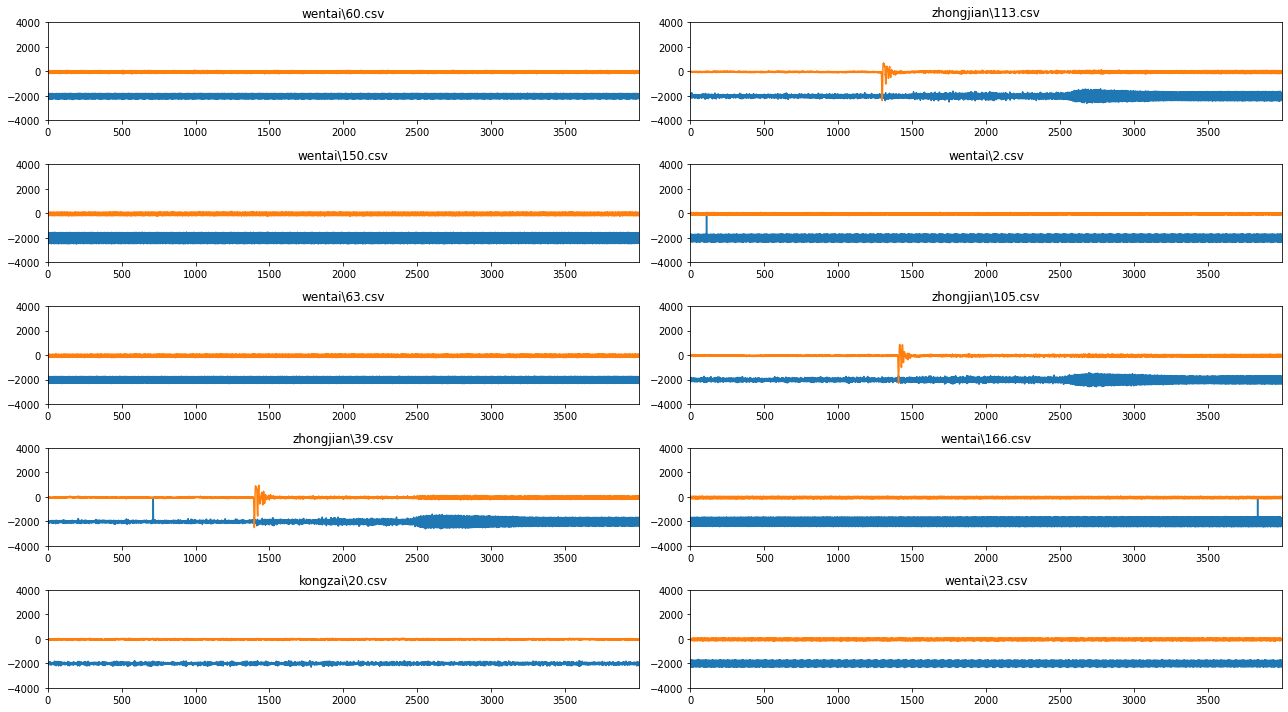

In [3]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

## Frame data

Each capture is framed into smaller windows. The window size will be the input dimension for the neural network. Optional overlapping can be added to further increase the number of points in our data for training and testing.

Here we are dividing the dataset into 1 second frames (26 samples at 26 Hz):

In [4]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.
    
    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 2))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 4000, 2000) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(503, 1, 4000, 2)
(503, 4000, 2)
(503,)
['zhongjian', 'wentai', 'kongzai']


## Preprocessing the dataset

To improve the model's performance, it is recommended to perform some kind of pre-processing on the input data before feeding them to the neural network model. Data pre-processing can include filtering, gravity rotation and/or suppression as it is done in [FP-AI-SENSING1]. In this example, a simple data scaling will suffice.

Data scaling can be achieved by normalizing or standardizing input data. In this example, data is normalized into floating point values between `-1.0` and `1.0` by dividing them by the sensor's full range (`4000 mg`).

[FP-AI-SENSING1]:https://www.st.com/en/embedded-software/fp-ai-sensing1.html

In [5]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

### Preparing the dataset (train, test, split)
The dataset is split into a _train_ and _test_ set. The data is first shuffled and then split with 25% reserved for model evaluation and testing purposes.

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_frames_normed, y_frames, test_size=0.25)

print("Trainning samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Trainning samples: (377, 4000, 2)
Testing samples: (126, 4000, 2)


In [7]:
### Time Distributed ConvNet imports ###
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D, AveragePooling1D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
#from tensorflow.keras.utils import np_utils
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

In [34]:
#The First CNN-LSTM
input = tf.keras.layers.Input(shape=(4000, 2))
'''
print(input.shape)
lstm = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(input)
print(lstm.shape)
lstm = TimeDistributed(MaxPooling1D(pool_size=2))(lstm)
print(lstm.shape)
lstm = TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'))(lstm)
print(lstm.shape)
lstm = TimeDistributed(Dropout(0.5))(lstm)
print(lstm.shape)
lstm = TimeDistributed(MaxPooling1D(pool_size=2))(lstm)
print(lstm.shape)
lstm =TimeDistributed(Flatten())(lstm)
print(lstm.shape)
'''
print(input.shape)

lstm = Conv1D(filters=64, kernel_size=3, activation='relu')(input)
print(lstm.shape)

lstm = MaxPooling1D(pool_size=2)(lstm)
print(lstm.shape)
lstm = Conv1D(filters=64, kernel_size=3, activation='relu')(lstm)
print(lstm.shape)


lstm = MaxPooling1D(pool_size=2)(lstm)
print(lstm.shape)

lstm = LSTM(64)(lstm)
print(lstm.shape)
lstm = Dropout(0.3)(lstm)
print(lstm.shape)
lstm =Flatten()(lstm)
print(lstm.shape)
outputs = tf.keras.layers.Dense(7, activation='softmax')(lstm)
print(outputs.shape)
lstm = keras.Model(input, outputs)

'''
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
'''

(None, 4000, 2)
(None, 3998, 64)
(None, 1999, 64)
(None, 1997, 64)
(None, 998, 64)
(None, 64)
(None, 64)
(None, 64)
(None, 3)


"\nmodel = Sequential()\nmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))\nmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))\nmodel.add(TimeDistributed(Dropout(0.5)))\nmodel.add(TimeDistributed(MaxPooling1D(pool_size=2)))\nmodel.add(TimeDistributed(Flatten()))\nmodel.add(LSTM(100))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(10, activation='relu'))\nmodel.add(Dense(3, activation='sigmoid'))\n"

In [36]:

# 查看模型
lstm.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

"""
# 训练模型
#history = lstm.fit(x_train, y_train, batch_size=32, epochs=60, validation_split=0.1)

lstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
"""
lstm.fit(x_train, y_train, epochs=100)
lstm.summary()
test_loss, test_acc = lstm.evaluate(x_test,  y_test, verbose=2)

Epoch 1/100
12/12 [==============================] - 0s 33ms/step - loss: 0.7467 - accuracy: 0.5889
Epoch 2/100
12/12 [==============================] - 0s 32ms/step - loss: 0.6584 - accuracy: 0.6684
Epoch 3/100
12/12 [==============================] - 0s 32ms/step - loss: 0.5679 - accuracy: 0.7082
Epoch 4/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4905 - accuracy: 0.6631
Epoch 5/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4769 - accuracy: 0.6631
Epoch 6/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4931 - accuracy: 0.6870
Epoch 7/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4891 - accuracy: 0.6631
Epoch 8/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4852 - accuracy: 0.6764
Epoch 9/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4588 - accuracy: 0.6950
Epoch 10/100
12/12 [==============================] - 0s 32ms/step - loss: 0.4731 - accuracy: 0.6525

In [8]:
#The 2nd CNN-LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
 
model = Sequential()
model.add(layers.Conv1D(64, 15, strides=2,input_shape=(4000, 2), use_bias=False))
model.add(layers.ReLU())
model.add(layers.Conv1D(64, 3))
model.add(layers.Conv1D(64, 3, strides=2))
model.add(layers.ReLU())
model.add(layers.Conv1D(64, 3))
model.add(layers.Conv1D(64, 3, strides=2))  # [None, 54, 64]
model.add(layers.BatchNormalization())
model.add(layers.LSTM(64, dropout=0.5, return_sequences=True))
model.add(layers.LSTM(64, dropout=0.5, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(3, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1993, 64)          1920      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 1993, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1991, 64)          12352     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 995, 64)           12352     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 995, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 993, 64)           12352     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 496, 64)          

In [19]:
#The change of 2nd CNN-LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
 
model = Sequential()
model.add(layers.Conv1D(64, 15, strides=2,input_shape=(4000, 2), use_bias=False))
model.add(layers.ReLU())
model.add(layers.Conv1D(64, 3))
model.add(layers.Conv1D(64, 3, strides=2))
model.add(layers.ReLU())
model.add(layers.Conv1D(64, 3))
model.add(layers.Conv1D(64, 3, strides=2))  # [None, 54, 64]
model.add(layers.BatchNormalization())
model.add(layers.LSTM(64, dropout=0.3, return_sequences=True))
model.add(layers.LSTM(64, dropout=0.3, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(3, activation="softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 1993, 64)          1920      
_________________________________________________________________
re_lu_10 (ReLU)              (None, 1993, 64)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1991, 64)          12352     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 995, 64)           12352     
_________________________________________________________________
re_lu_11 (ReLU)              (None, 995, 64)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 993, 64)           12352     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 496, 64)          

In [20]:
# 查看模型
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

"""
# 训练模型
#history = lstm.fit(x_train, y_train, batch_size=32, epochs=60, validation_split=0.1)

lstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
"""
model.fit(x_train, y_train, epochs=100)
model.summary()
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/100
12/12 [==============================] - 1s 46ms/step - loss: 0.9600 - accuracy: 0.5544
Epoch 2/100
12/12 [==============================] - 1s 44ms/step - loss: 0.5210 - accuracy: 0.6631
Epoch 3/100
12/12 [==============================] - 1s 43ms/step - loss: 0.5329 - accuracy: 0.6605
Epoch 4/100
12/12 [==============================] - 1s 44ms/step - loss: 0.4623 - accuracy: 0.6605
Epoch 5/100
12/12 [==============================] - 1s 43ms/step - loss: 0.4575 - accuracy: 0.6870
Epoch 6/100
12/12 [==============================] - 1s 44ms/step - loss: 0.4576 - accuracy: 0.6684
Epoch 7/100
12/12 [==============================] - 1s 43ms/step - loss: 0.4523 - accuracy: 0.6870
Epoch 8/100
12/12 [==============================] - 1s 43ms/step - loss: 0.4464 - accuracy: 0.7162
Epoch 9/100
12/12 [==============================] - 1s 43ms/step - loss: 0.4418 - accuracy: 0.7188
Epoch 10/100
12/12 [==============================] - 1s 43ms/step - loss: 0.4420 - accuracy: 0.7162

## Creating the model

Let's create a classifier model using Keras.

Build the tf.keras.Sequential model by stacking layers. Choose an optimizer and loss function for training:

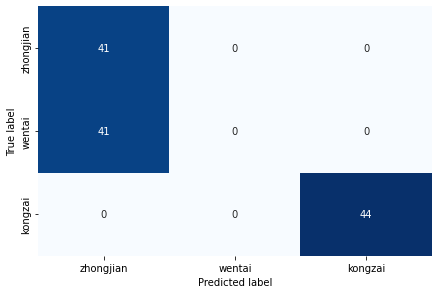

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = lstm.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

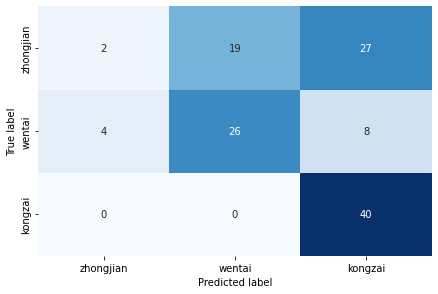

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
# Save the model into an HDF5 file ‘model.h5’
lstm.save('CNN-LSTM.h5')

In [10]:
model.save('CNN-LSTM-NEW.h5')

In [33]:
import tensorflow as tf

model = tf.keras.models.load_model('CNN-LSTM.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('CNN-LSTM.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model = tf.keras.models.load_model('CNN-LSTM-NEW.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('CNN-LSTM-NEW.tflite', 'wb') as f:
  f.write(tflite_model)